# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Background/ Business Problem
A person wants to open an Italian restaurant in Hamburg. Finding a suitable spot for Italien restaurant is particularly challenging because there are many Italien restaurant in Hamburg. Therefore he wants to use data science an machine learning learning techniques to find a suitable location for his restaurant. Restaurant should ideally be located in part of Hamburg where the owner could get a significant customer base. He is targetting the mid to upper segment of the market so this should also be taken into consideration.\
There are many neighborhoods in Hamburg some more affluent then the others and the population density also varies between the different parts of the city. The aim of this project is to shortlist suitable locations taking these factors into consideration.

## Description of Data
The Data used for this project is as follows:
1. A list of all the neighborhoods in Hamburg including their population density is taken from the wikipedia page:\
https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Stadtteile_Hamburgs \
Webscraping is used to read the relevant data on this webpage.

2. The data on the average income in each neighborhood is taken from the report this website:\
https://www.statistik-nord.de/fileadmin/Dokumente/Statistik_informiert_SPEZIAL/SI_SPEZIAL_VIII_2017.pdf  
A csv file is generated using the data in this pdf and read into pandas dataframe.

3. The data on venues in each neighborhood serving food is obtained using the Foursquare places API. 

From these sources, data on the population density, average income and the number and type of food venues will be used to shortlist potential locations for an Italian restaurant.

In [319]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt  
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import requests
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


# Methodology section
This section will be devoted to execution of all the steps required in this project. This section will consist of:
1. Data Collection
2. Exploring Data
3. Preprocessing data for analysis
4. Clustering data using K-Means Clustering

##  1. Data Collection

### I have already done webscraping and saved the data in csv file so it will read directly. The commands used for webscraping are also listed below

In [5]:
df_hamburg= pd.read_csv('Hamburg_neighborhoods_data.csv', index_col=0)

In [330]:
df_hamburg.head()

,Neighborhood,Borough,Population,Population_per_km2,latitude,longitude
0,Hamburg-Altstadt,Hamburg-Mitte,2350,979,53.550468,9.994640
1,HafenCity,Hamburg-Mitte,4925,2239,53.542913,9.995835
2,Neustadt,Hamburg-Mitte,12762,5549,53.549881,9.979048
3,St. Pauli,Hamburg-Mitte,22097,8839,53.553935,9.959432
4,St. Georg,Hamburg-Mitte,11358,4733,53.556993,10.014162


In [68]:
print("Total number of neighborhoods in Hamburg is",df_hamburg.shape[0])

Total number of neighborhoods in Hamburg is 104


### The code below is used for webscraping. It can be used to generate the above dataframe

In [5]:
import requests

In [6]:
wiki_url='https://de.wikipedia.org/wiki/Liste_der_Bezirke_und_Stadtteile_Hamburgs'
response=requests.get(wiki_url)
soup1=BeautifulSoup(response.text,'html.parser')

In [7]:
table_ham=soup1.find_all('table')[1]

In [8]:
#getting the data into a pandas dataframe
df=pd.read_html(str(table_ham),thousands='.')

In [9]:
df_hamburg=df[0].copy()

In [ ]:
df_hamburg.columns

In [11]:
df_hamburg.drop(['Fläche(km²)','Karte','Ortsteile'],axis=1,inplace=True)

In [12]:
df_hamburg.columns=['Neighborhood','Borough','Population','Population_per_km2','Location']

In [ ]:
df_hamburg.head()

In [14]:
def get_lat_long(locations):
    lat=[]
    long=[]
    for neighborhood in locations:
        address = neighborhood+',Hamburg'
        geolocator = Nominatim(user_agent="http")
        location = geolocator.geocode(address)
        lat.append(location.latitude)
        long.append(location.longitude)
        time.sleep(1)#this is done not to overload server with repeated requests
    return lat, long

In [ ]:
latitude,longitude=get_lat_long(df_hamburg['Neighborhood'])

In [ ]:
df_hamburg['latitude']=latitude
df_hamburg['longitude']=longitude
df_hamburg.head()

In [ ]:
df_hamburg.drop(columns='Location',inplace=True)

In [ ]:
# Data is saved to csv file so that we don't have to do webscraping every time we run the notebooks
df_hamburg.to_csv('Hamburg_neighborhoods_data.csv')

### Plotting neighborhoods on map of Hamburg

In [67]:
#Getting coordinates of hamburg
address = 'Hamburg, Germany'

geolocator = Nominatim(user_agent="ham_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hamburg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hamburg are 53.5437641, 10.0099133.


In [68]:
#Plotting neighborhoods in Hamburg
map_hamburg = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_hamburg['latitude'], df_hamburg['longitude'], df_hamburg['Neighborhood']):
    label = folium.Popup(label, parse_html=True,show=False)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_hamburg) 
map_hamburg

### Importing Income data from excel file

In [7]:
df_income=pd.read_excel('data_income_hamburg.xlsx')

In [8]:
#checking if all the neighborhoods are present in the income dataframe
df_hamburg[~df_hamburg['Neighborhood'].isin(df_income['Neighborhood'])]

,Neighborhood,Borough,Population,Population_per_km2,latitude,longitude
18,Neuwerk,Hamburg-Mitte,30,4,53.922422,8.502859


The above neighborhood is not present in income data so we use average income for this neighborhood

In [9]:
# Adding income data to the df_hamburg dataframe
df_hamburg=df_hamburg.merge(df_income,on='Neighborhood',how='left')

In [10]:
# Filling out the missing income data with average income
mean_salary=int(df_hamburg['Average income'].mean())
print(mean_salary)
df_hamburg[['Average income']]=df_hamburg[['Average income']].fillna(mean_salary)

41585


In [11]:
df_hamburg.head()

,Neighborhood,Borough,Population,Population_per_km2,latitude,longitude,Average income
0,Hamburg-Altstadt,Hamburg-Mitte,2350,979,53.550468,9.994640,31336.0
1,HafenCity,Hamburg-Mitte,4925,2239,53.542913,9.995835,93206.0
2,Neustadt,Hamburg-Mitte,12762,5549,53.549881,9.979048,34521.0
3,St. Pauli,Hamburg-Mitte,22097,8839,53.553935,9.959432,27977.0
4,St. Georg,Hamburg-Mitte,11358,4733,53.556993,10.014162,44121.0


### Connecting to Foursquare to get data on restaurants in Hamburg

In [ ]:
#The credentials are deliberately changed to avoid misuse
CLIENT_ID = 'AXOYK3TDB3G2HJRXXXXXXXX31UD5HR3AEX4R0KB5FJO0C' # your Foursquare ID
CLIENT_SECRET = 'A5AEG0K1FNDFVOTGHEXXXXXXXXFNFHQAJAKBYF3LT522ZI' # your Foursquare Secret
VERSION = '20220629' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#### In the getNearbyVenues function the food category id is used so that only venues serving food are gathered

In [89]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore'

        params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v='20200713',
        ll=f'{lat},{lng}',
        radius=radius,
        limit=100,
        sortByDistance=1,
        categoryId='4d4b7105d754a06374d81259', # food Category
        time='any',
        day='any'
        )
        resp = requests.get(url=url, params=params)
        #results=resp
        results = json.loads(resp.text)
            
        # make the GET request
        venues=results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venues])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [233]:
hamburg_food = getNearbyVenues(names=df_hamburg['Neighborhood'],
                                   latitudes=df_hamburg['latitude'],
                                   longitudes=df_hamburg['longitude']
                                  )

Hamburg-Altstadt
HafenCity
Neustadt
St. Pauli
St. Georg
Hammerbrook
Borgfelde
Hamm
Horn
Billstedt
Billbrook
Rothenburgsort
Veddel
Wilhelmsburg
Kleiner Grasbrook
Steinwerder
Waltershof
Finkenwerder
Neuwerk
Altona-Altstadt
Sternschanze
Altona-Nord
Ottensen
Bahrenfeld
Groß Flottbek
Othmarschen
Lurup
Osdorf
Nienstedten
Blankenese
Iserbrook
Sülldorf
Rissen
Eimsbüttel
Rotherbaum
Harvestehude
Hoheluft-West
Lokstedt
Niendorf
Schnelsen
Eidelstedt
Stellingen
Hoheluft-Ost
Eppendorf
Groß Borstel
Alsterdorf
Winterhude
Uhlenhorst
Hohenfelde
Barmbek-Süd
Dulsberg
Barmbek-Nord
Ohlsdorf
Fuhlsbüttel
Langenhorn
Eilbek
Wandsbek
Marienthal
Jenfeld
Tonndorf
Farmsen-Berne
Bramfeld
Steilshoop
Wellingsbüttel
Sasel
Poppenbüttel
Hummelsbüttel
Lemsahl-Mellingstedt
Duvenstedt
Wohldorf-Ohlstedt
Bergstedt
Volksdorf
Rahlstedt
Lohbrügge
Bergedorf
Curslack
Altengamme
Neuengamme
Kirchwerder
Ochsenwerder
Reitbrook
Allermöhe
Billwerder
Moorfleet
Tatenberg
Spadenland
Neuallermöhe
Harburg
Neuland
Gut Moor
Wilstorf
Rönneburg


## 2. Exploring and Cleaning Data

I have saved the foursquare data to csv file so that I don't have to get it from foursquare everytime I run the code.

In [13]:
#Reading data from already saved csv file to save time
hamburg_food= pd.read_csv('Hamburg_food.csv', index_col=0)

Checking how many unique sub categories are found in Hamburg under the food category

In [15]:
print('There are {} uniques categories.'.format(len(hamburg_food['Venue Category'].unique())))

There are 96 uniques categories.


In [241]:
hamburg_food.shape

(3430, 7)

In [17]:
hamburg_food.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hamburg-Altstadt,53.550468,9.99464,Café Paris,53.550106,9.994227,Café
1,Hamburg-Altstadt,53.550468,9.99464,frittenwerk,53.551136,9.994500,Fast Food Restaurant
2,Hamburg-Altstadt,53.550468,9.99464,Pastaria Da Franco,53.551148,9.994428,Italian Restaurant
3,Hamburg-Altstadt,53.550468,9.99464,Salam-City,53.549939,9.995543,Falafel Restaurant
4,Hamburg-Altstadt,53.550468,9.99464,Picasso,53.549934,9.995627,Spanish Restaurant


In [16]:
hamburg_food.groupby('Venue Category').count().sort_values(by='Venue',ascending=False).head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bakery,402,402,402,402,402,402
Café,399,399,399,399,399,399
Italian Restaurant,242,242,242,242,242,242
German Restaurant,226,226,226,226,226,226
Restaurant,186,186,186,186,186,186


We see that bakeries form a significant number of the venues found. We will remove bakeries from our dataframe because they don't stand in direct competition to a restaurant. 

In [18]:
remove_category='Bakery'
hamburg_food=hamburg_food[~hamburg_food['Venue Category'].isin([remove_category])]

In [19]:
total_venues=hamburg_food.groupby('Neighborhood').count()[['Venue Category']]
total_venues.columns=['total_venues']
total_venues.reset_index(inplace=True)

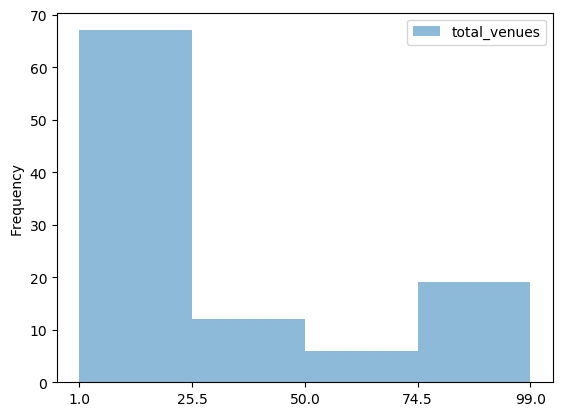

In [334]:
count,bin_edges=np.histogram(total_venues['total_venues'],bins=4)
total_venues[['total_venues']].plot.hist(bins=4, alpha=0.5,xticks=bin_edges )

In this project neighborhoods of Hamburg are analysed to shortlist optimium locations for opening an Italian restaurant catering to the mid to upper end segment of the market. Taking the targeted customers into consideration locations are shortlisted using data on food venues from foursquare api, and information on average income and population density available on the internet.  
Five neighborhoods are shortlisted where the population have high buying power and the competition is low. Final de

We see that most of the neighborhoods have under 25 food venues. These bins can be classified as low, medium, high and very high competition.

[72 20  8  4]


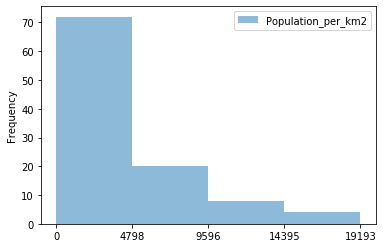

In [125]:
#population density
count,bin_edges=np.histogram(df_hamburg['Population_per_km2'],bins=4)
df_hamburg[['Population_per_km2']].plot.hist(bins=4, alpha=0.5,xticks=bin_edges )
print(count)

Most of the neighborhoods in Hamburg have a population density of under 4798. The population density can be classified into low/average, medium, high and very high.

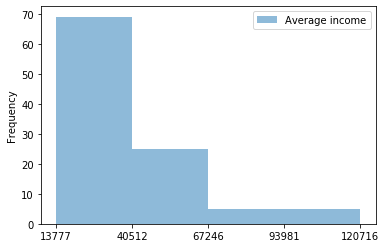

In [71]:
#income
count,bin_edges=np.histogram(df_hamburg['Average income'],bins=4)
df_hamburg[['Average income']].plot.hist(bins=4, alpha=0.5,xticks=bin_edges)

The income is divided here into 4 bins. These can be classified as low/average, medium, high and very high.

## 3. Preprocessing data for analysis

Converting Categories of restaurants into numeric variable with one hot Encoding technique

In [20]:
# one hot encoding
hamburg_onehot = pd.get_dummies(hamburg_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hamburg_onehot['Neighborhood'] = hamburg_food['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hamburg_onehot.columns[-1]] + list(hamburg_onehot.columns[:-1])
hamburg_onehot = hamburg_onehot[fixed_columns]

hamburg_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bavarian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Kumpir Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Paella Restaurant,Pakistani Restaurant,Palatine Restaurant,Persian Restaurant,Peruvian Restaurant,Pide Place,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Schnitzel Restaurant,Seafood Restaurant,Snack Place,Soup Place,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swabian Restaurant,Szechuan Restaurant,Tapas Restaurant,Taverna,Thai Restaurant,Theme Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hamburg-Altstadt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
hamburg_grouped=hamburg_onehot.groupby('Neighborhood').mean().reset_index()
hamburg_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bavarian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Halal Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Kumpir Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mongolian Restaurant,Moroccan Restaurant,Paella Restaurant,Pakistani Restaurant,Palatine Restaurant,Persian Restaurant,Peruvian Restaurant,Pide Place,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Schnitzel Restaurant,Seafood Restaurant,Snack Place,Soup Place,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swabian Restaurant,Szechuan Restaurant,Tapas Restaurant,Taverna,Thai Restaurant,Theme Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Allermöhe,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,Alsterdorf,0.0,0.0,0.0,0.0,0.074074,0.000000,0.0,0.0,0.0,0.000000,0.0,0.037037,0.037037,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.037037,0.074074,0.0,0.0,0.0,0.0,0.0,0.037037,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.037037,0.074074,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.037037,0.000000,0.0,0.0,0.000000,0.037037,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.222222,0.037037,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.0,0.000000,0.0,0.037037,0.0,0.000000,0.000000,0.0,0.000000,0.074074,0.0
2,Altengamme,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,Altenwerder,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0000

#### Normalizing data on population density, income and total number of venues to be used to KMeans Clustering

In [22]:
df_clust=df_hamburg[['Neighborhood','Population_per_km2','Average income']].copy()

In [23]:
df_clust=df_clust.merge(total_venues,on='Neighborhood')

In [24]:
df_clust.head()

,Neighborhood,Population_per_km2,Average income,total_venues
0,Hamburg-Altstadt,979,31336.0,97
1,HafenCity,2239,93206.0,93
2,Neustadt,5549,34521.0,99
3,St. Pauli,8839,27977.0,98
4,St. Georg,4733,44121.0,94


In [25]:
scaled_array=StandardScaler().fit_transform(df_clust[['Population_per_km2','Average income','total_venues']])

In [26]:
df_clust_norm=pd.DataFrame(scaled_array)

In [27]:
df_clust_norm.insert(0,'Neighborhood',value=df_clust['Neighborhood'])

In [28]:
df_clust_norm.columns=df_clust.columns

In [29]:
df_clust_norm.head()

,Neighborhood,Population_per_km2,Average income,total_venues
0,Hamburg-Altstadt,-0.726399,-0.480244,2.042690
1,HafenCity,-0.434408,2.418739,1.922328
2,Neustadt,0.332648,-0.331008,2.102871
3,St. Pauli,1.095069,-0.637634,2.072781
4,St. Georg,0.143549,0.118810,1.952418


#### Sorting venues in descending order to have a look at what type of food venues are most common each neighborhood.

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hamburg_grouped['Neighborhood']

for ind in np.arange(hamburg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hamburg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allermöhe,German Restaurant,Wings Joint,Food Truck,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
1,Alsterdorf,Restaurant,Café,Vietnamese Restaurant,Asian Restaurant,Greek Restaurant,Doner Restaurant,Burger Joint,German Restaurant,Lebanese Restaurant,Fast Food Restaurant
2,Altengamme,Diner,Café,Food Truck,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food
3,Altenwerder,Diner,Gastropub,Food Truck,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
4,Altona-Altstadt,Café,Seafood Restaurant,Italian Restaurant,Restaurant,Pizza Place,German Restaurant,Burger Joint,French Restaurant,Asian Restaurant,Thai Restaurant
5,Altona-Nord,Café,Pizza Place,Burger Joint,German Restaurant,Asian Restaurant,Indian Restaurant,Vietnamese Restaurant,Restaurant,Italian Restaurant,French Restaurant
6,Bahrenfeld,Restaurant,Italian Restaurant,German Restaurant,Café,Snack Place,Indian Restaurant,BBQ Joint,Asian Restaurant,Diner,Fast Food Restaurant
7,Barmbek-Nord,Café,Italian Restaurant,Taverna,German Restaurant,Fast Food Restaurant,Falafel Restaurant,Greek Restaurant,Asian Restaurant,Thai Restaurant,Indian Restaurant
8,Barmbek-Süd,Café,German Restaurant,Doner Restaurant,Italian Restaurant,Indian Restaurant,Fast Food Restaurant,Pizza Place,Greek Restaurant,Taverna,Vietnamese Restaurant
9,Bergedorf,Restaurant,German Restaurant,Falafel Restaurant,Fast Food Restaurant,Café,Burger Joint,Asian Restaurant,Trattoria/Osteria,Sushi Restaurant,Steakhouse


## 4. Clustering data using K-Means clustering

#### To Find the optimum value of K (number of clusters) yellowbrick package will be used which has a fuction for finding the optimum value of K

In [32]:
from yellowbrick.cluster import KElbowVisualizer

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [60]:
hamburg_grouped_clustering = df_clust_norm[['Population_per_km2','Average income','total_venues']]
model=KMeans(random_state=0)
visualizer = KElbowVisualizer(
    model, k=(4,15), metric='calinski_harabasz', timings=False
)

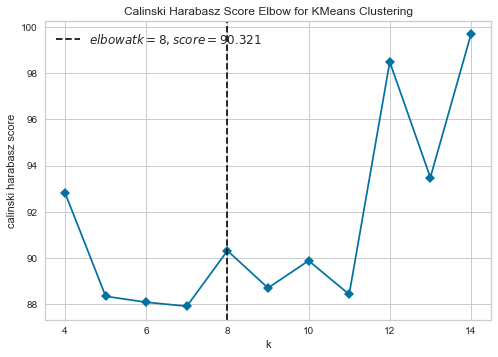

In [61]:
visualizer.fit(hamburg_grouped_clustering)
visualizer.show()

### The plot above shows that the optimum value of K is 8

In [62]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hamburg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 7, 3, 0, 3, 5, 0, 0, 5, 5])

#### Adding Clustering labels and data on the most common venues found earlier to make one dataframe with all the usefull information

In [65]:
# add clustering labels

hamburg_merged = df_hamburg.drop(['Borough','Average income'],axis=1)
hamburg_merged.insert(3,'Average income',df_clust['Average income'])
hamburg_merged.insert(4,'total_venues',df_clust['total_venues'])
hamburg_merged.insert(5,'Cluster Labels',kmeans.labels_)

hamburg_merged = hamburg_merged.merge(neighborhoods_venues_sorted, on='Neighborhood')

hamburg_merged.head()

,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hamburg-Altstadt,2350,979,31336.0,97,3,53.550468,9.994640,German Restaurant,Italian Restaurant,Asian Restaurant,Café,Steakhouse,Vietnamese Restaurant,Burger Joint,Restaurant,Seafood Restaurant,French Restaurant
1,HafenCity,4925,2239,93206.0,93,7,53.542913,9.995835,German Restaurant,Italian Restaurant,Café,Restaurant,Asian Restaurant,Bistro,Seafood Restaurant,Burger Joint,Vietnamese Restaurant,French Restaurant
2,Neustadt,12762,5549,34521.0,99,3,53.549881,9.979048,Café,German Restaurant,Italian Restaurant,Seafood Restaurant,Steakhouse,French Restaurant,Trattoria/Osteria,Restaurant,Austrian Restaurant,Burger Joint
3,St. Pauli,22097,8839,27977.0,98,0,53.553935,9.959432,Café,Seafood Restaurant,Restaurant,German Restaurant,Pizza Place,Burger Joint,Asian Restaurant,Gastropub,Austrian Restaurant,Italian Restaurant
4,St. Georg,11358,4733,44121.0,94,3,53.556993,10.014162,Italian Restaurant,Café,Restaurant,German Restaurant,Vietnamese Restaurant,Burger Joint,Asian Restaurant,French Restaurant,Mediterranean Restaurant,Thai Restaurant


In [348]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
test=['black', 'blue', 'red', 'darkblue', 'darkgreen', 'darkpurple', 'darkred', 'green', 'lightblue', 'lightgreen', 'lightred', 'orange', 'pink', 'purple']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hamburg_merged['latitude'], hamburg_merged['longitude'], hamburg_merged['Neighborhood'], hamburg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True,sticky=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=test[cluster-1],
        fill=True,
        fill_color=test[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analysing clusters

In [143]:
clusters=[]
for i in range(8):
    clusters.append(hamburg_merged.loc[hamburg_merged['Cluster Labels'] == i].drop(labels=['latitude','longitude'],axis=1))

In [147]:
#Cluster 1
clusters[0]

,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,St. Pauli,22097,8839,27977.0,98,0,Café,Seafood Restaurant,Restaurant,German Restaurant,Pizza Place,Burger Joint,Asian Restaurant,Gastropub,Austrian Restaurant,Italian Restaurant
6,Borgfelde,8343,10429,26217.0,84,0,Italian Restaurant,Café,Asian Restaurant,German Restaurant,Restaurant,Fast Food Restaurant,Doner Restaurant,Diner,Pizza Place,Vietnamese Restaurant
7,Hamm,38330,9583,25745.0,38,0,Café,Greek Restaurant,German Restaurant,Fast Food Restaurant,Restaurant,Gastropub,Pizza Place,Kebab Restaurant,Middle Eastern Restaurant,Food
19,Altona-Altstadt,29169,10418,30833.0,93,0,Café,Seafood Restaurant,Italian Restaurant,Restaurant,Pizza Place,German Restaurant,Burger Joint,French Restaurant,Asian Restaurant,Thai Restaurant
21,Altona-Nord,24536,11153,29901.0,83,0,Café,Pizza Place,Burger Joint,German Restaurant,Asian Restaurant,Indian Restaurant,Vietnamese Restaurant,Restaurant,Italian Restaurant,French Restaurant
22,Ottensen,35585,12709,40830.0,68,0,Café,German Restaurant,Italian Restaurant,Pizza Place,Steakhouse,Asian Restaurant,Restaurant,Seafood Restaurant,Greek Restaurant,Doner Restaurant
46,Winterhude,55491,7301,51627.0,49,0,Café,Bistro,German Restaurant,Sushi Restaurant,Restaurant,Burger Joint,Diner,Doner Restaurant,Mediterranean Restaurant,Vietnamese Restaurant
48,Hohenfelde,10034,9122,39541.0,91,0,Italian Restaurant,German Restaurant,Café,Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Doner Restaurant,Vietnamese Restaurant,Portuguese Restaurant
49,Barmbek-Süd,35827,11557,32679.0,80,0,Café,German Restaurant,Doner Restaurant,Italian Restaurant,Indian Restaurant,Fast Food Restaurant,Pizza Place,Greek Restaurant,Taverna,Vietnamese Restaurant
50,Dulsberg,17229,14358,21239.0,58,0,Café,German Restaurant,Asian Restaurant,Turkish Restaurant,Falafel Restaurant,Doner Restaurant,Chinese Restaurant,Greek Restaurant,Steakhouse,Vietnamese Restaurant


In [148]:
#Cluster 2
clusters[1]

,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Billbrook,1740,285,22625.0,6,1,BBQ Joint,Wings Joint,Café,Food Truck,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
12,Veddel,4475,1017,15831.0,9,1,Restaurant,German Restaurant,Seafood Restaurant,Café,Gastropub,Italian Restaurant,Greek Restaurant,Fast Food Restaurant,Doner Restaurant,Dumpling Restaurant
13,Wilhelmsburg,53518,1512,21890.0,8,1,German Restaurant,Restaurant,Turkish Restaurant,Bistro,Fast Food Restaurant,Food Court,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant
14,Kleiner Grasbrook,1108,246,13777.0,20,1,Italian Restaurant,German Restaurant,Bistro,Café,Breakfast Spot,Restaurant,Food,Modern European Restaurant,Seafood Restaurant,Middle Eastern Restaurant
16,Waltershof,0,0,31649.0,2,1,Diner,Gastropub,Food Truck,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
17,Finkenwerder,11754,597,31649.0,3,1,Seafood Restaurant,German Restaurant,Wings Joint,Food Court,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
18,Neuwerk,30,4,41585.0,4,1,German Restaurant,Seafood Restaurant,Café,Wings Joint,Food Court,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
31,Sülldorf,9436,1655,43584.0,3,1,Asian Restaurant,Greek Restaurant,German Restaurant,Wings Joint,Food Truck,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
66,Hummelsbüttel,18394,2021,38135.0,11,1,Italian Restaurant,Greek Restaurant,Restaurant,Chinese Restaurant,Burger Joint,German Restaurant,Steakhouse,Doner Restaurant,Asian Restaurant,BBQ Joint
75,Curslack,4036,381,41512.0,4,1,German Restaurant,Gastropub,Wings Joint,Food Court,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant


In [149]:
#Cluster 3
clusters[2]

,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Groß Flottbek,11111,4630,85952.0,37,2,Café,Italian Restaurant,Restaurant,Indian Restaurant,Asian Restaurant,German Restaurant,Sushi Restaurant,Snack Place,Doner Restaurant,Portuguese Restaurant
25,Othmarschen,15737,2623,108258.0,18,2,Café,German Restaurant,Restaurant,Burger Joint,Falafel Restaurant,Deli / Bodega,Steakhouse,Sushi Restaurant,Italian Restaurant,Brazilian Restaurant
28,Nienstedten,7181,1670,120716.0,17,2,Café,Seafood Restaurant,Snack Place,Restaurant,German Restaurant,French Restaurant,Portuguese Restaurant,Diner,Fried Chicken Joint,Ethiopian Restaurant
29,Blankenese,13730,1783,117139.0,26,2,Café,Seafood Restaurant,Restaurant,Snack Place,Italian Restaurant,French Restaurant,Fast Food Restaurant,Steakhouse,Sushi Restaurant,Burger Joint
63,Wellingsbüttel,10848,2646,88606.0,26,2,Italian Restaurant,Café,Sushi Restaurant,Trattoria/Osteria,Seafood Restaurant,Pizza Place,Eastern European Restaurant,Restaurant,Sandwich Place,Burger Joint
69,Wohldorf-Ohlstedt,4650,269,94234.0,5,2,German Restaurant,Wings Joint,Food Truck,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop


In [150]:
#Cluster 4
clusters[3]

,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hamburg-Altstadt,2350,979,31336.0,97,3,German Restaurant,Italian Restaurant,Asian Restaurant,Café,Steakhouse,Vietnamese Restaurant,Burger Joint,Restaurant,Seafood Restaurant,French Restaurant
2,Neustadt,12762,5549,34521.0,99,3,Café,German Restaurant,Italian Restaurant,Seafood Restaurant,Steakhouse,French Restaurant,Trattoria/Osteria,Restaurant,Austrian Restaurant,Burger Joint
4,St. Georg,11358,4733,44121.0,94,3,Italian Restaurant,Café,Restaurant,German Restaurant,Vietnamese Restaurant,Burger Joint,Asian Restaurant,French Restaurant,Mediterranean Restaurant,Thai Restaurant
15,Steinwerder,33,4,13777.0,97,3,Portuguese Restaurant,Café,Seafood Restaurant,Italian Restaurant,German Restaurant,Burger Joint,Restaurant,Pizza Place,Fast Food Restaurant,Snack Place
56,Wandsbek,36443,6074,28567.0,56,3,Café,Chinese Restaurant,Asian Restaurant,Greek Restaurant,Italian Restaurant,German Restaurant,BBQ Joint,Taverna,Doner Restaurant,Sushi Restaurant


In [151]:
#Cluster 5
clusters[4]

,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Rissen,15886,951,65855.0,3,4,Indian Restaurant,German Restaurant,Café,Wings Joint,Food Court,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
45,Alsterdorf,15204,4751,52426.0,27,4,Restaurant,Café,Vietnamese Restaurant,Asian Restaurant,Greek Restaurant,Doner Restaurant,Burger Joint,German Restaurant,Lebanese Restaurant,Fast Food Restaurant
57,Marienthal,13521,4225,59131.0,42,4,Chinese Restaurant,Asian Restaurant,Café,Turkish Restaurant,Italian Restaurant,Doner Restaurant,Burger Joint,Seafood Restaurant,Vietnamese Restaurant,Dumpling Restaurant
64,Sasel,23750,2827,61360.0,9,4,Asian Restaurant,Indian Restaurant,Trattoria/Osteria,Taverna,Chinese Restaurant,Gastropub,Sushi Restaurant,Food,Food Court,Eastern European Restaurant
65,Poppenbüttel,23901,2951,52157.0,24,4,Italian Restaurant,Restaurant,Fast Food Restaurant,Seafood Restaurant,Café,Sushi Restaurant,Deli / Bodega,Sandwich Place,Middle Eastern Restaurant,Steakhouse
67,Lemsahl-Mellingstedt,6852,857,75191.0,5,4,German Restaurant,Restaurant,Pizza Place,Seafood Restaurant,Food,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
68,Duvenstedt,6160,906,65694.0,5,4,Café,Pizza Place,German Restaurant,Modern European Restaurant,Burger Joint,Wings Joint,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
70,Bergstedt,10736,1534,51374.0,6,4,German Restaurant,Italian Restaurant,Snack Place,Pizza Place,Restaurant,BBQ Joint,Food Truck,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant
71,Volksdorf,20978,1808,63763.0,17,4,Café,Greek Restaurant,Italian Restaurant,Tapas Restaurant,Fast Food Restaurant,Seafood Restaurant,Doner Restaurant,Brazilian Restaurant,Steakhouse,German Restaurant


In [152]:
#Cluster 6
clusters[5]

,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Hammerbrook,4619,1540,19468.0,50,5,Restaurant,Café,German Restaurant,Italian Restaurant,Fast Food Restaurant,Asian Restaurant,Doner Restaurant,Gastropub,Bistro,BBQ Joint
8,Horn,38373,6504,21685.0,13,5,Doner Restaurant,Mediterranean Restaurant,German Restaurant,Sandwich Place,Café,Gastropub,Breakfast Spot,Greek Restaurant,BBQ Joint,Turkish Restaurant
9,Billstedt,70409,4142,23247.0,5,5,Asian Restaurant,Sandwich Place,Seafood Restaurant,Fast Food Restaurant,Café,Wings Joint,Food Court,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant
11,Rothenburgsort,9187,1241,20473.0,31,5,Italian Restaurant,Restaurant,German Restaurant,Asian Restaurant,Fast Food Restaurant,Café,Bagel Shop,Middle Eastern Restaurant,Diner,Indonesian Restaurant
23,Bahrenfeld,30203,2849,33565.0,41,5,Restaurant,Italian Restaurant,German Restaurant,Café,Snack Place,Indian Restaurant,BBQ Joint,Asian Restaurant,Diner,Fast Food Restaurant
26,Lurup,36610,5811,26665.0,12,5,German Restaurant,Taverna,Restaurant,Pizza Place,Fast Food Restaurant,Burger Joint,Gastropub,Steakhouse,Doner Restaurant,Asian Restaurant
27,Osdorf,26565,3690,43177.0,17,5,Café,Italian Restaurant,Sushi Restaurant,German Restaurant,Fast Food Restaurant,Doner Restaurant,Pizza Place,Indian Restaurant,Salad Place,Seafood Restaurant
30,Iserbrook,11423,4231,39439.0,2,5,Chinese Restaurant,Greek Restaurant,Wings Joint,Food Truck,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
37,Lokstedt,29373,5994,41778.0,17,5,Asian Restaurant,Italian Restaurant,Fast Food Restaurant,Steakhouse,Restaurant,Moroccan Restaurant,Modern European Restaurant,Café,Diner,Greek Restaurant
38,Niendorf,40838,3293,41651.0,17,5,Italian Restaurant,Greek Restaurant,Pizza Place,Bistro,Fast Food Restaurant,Doner Restaurant,Chinese Restaurant,Café,Steakhouse,Restaurant


In [154]:
#Cluster 7
clusters[6]

,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Sternschanze,8092,16184,31125.0,95,6,Café,Restaurant,Burger Joint,Vietnamese Restaurant,Gastropub,Falafel Restaurant,Pizza Place,Asian Restaurant,Austrian Restaurant,French Restaurant
33,Eimsbüttel,58004,17577,37536.0,91,6,Café,Restaurant,German Restaurant,Falafel Restaurant,French Restaurant,Asian Restaurant,Mexican Restaurant,Sushi Restaurant,Italian Restaurant,Breakfast Spot
36,Hoheluft-West,13435,19193,42169.0,93,6,Café,Italian Restaurant,Vietnamese Restaurant,Steakhouse,Pizza Place,Burger Joint,Thai Restaurant,German Restaurant,Greek Restaurant,Middle Eastern Restaurant
42,Hoheluft-Ost,9694,16157,52006.0,90,6,Café,Italian Restaurant,Vietnamese Restaurant,Steakhouse,Sushi Restaurant,Bistro,Pizza Place,Burger Joint,Tapas Restaurant,German Restaurant


In [155]:
#Cluster 8
clusters[7]

,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,HafenCity,4925,2239,93206.0,93,7,German Restaurant,Italian Restaurant,Café,Restaurant,Asian Restaurant,Bistro,Seafood Restaurant,Burger Joint,Vietnamese Restaurant,French Restaurant
34,Rotherbaum,16982,5661,68191.0,96,7,Café,Steakhouse,Restaurant,Italian Restaurant,French Restaurant,German Restaurant,Middle Eastern Restaurant,Burger Joint,Vietnamese Restaurant,Trattoria/Osteria
35,Harvestehude,17875,8512,111088.0,90,7,Café,Italian Restaurant,Sushi Restaurant,Restaurant,Mexican Restaurant,Steakhouse,Vietnamese Restaurant,Pizza Place,Spanish Restaurant,Vegetarian / Vegan Restaurant
43,Eppendorf,25070,9285,58438.0,89,7,Café,Italian Restaurant,Vietnamese Restaurant,Bistro,Sushi Restaurant,Gastropub,Vegetarian / Vegan Restaurant,Restaurant,Burger Joint,Trattoria/Osteria
47,Uhlenhorst,18634,8470,62479.0,92,7,Italian Restaurant,Café,Restaurant,Asian Restaurant,Tapas Restaurant,Sushi Restaurant,German Restaurant,Burger Joint,Steakhouse,Greek Restaurant


## Results and Discussion

#### Using Kmeans Clustering eight clusters are obtained. While analysing the clusters it can be seen that each cluster has neighborhoods grouped together which have similar charasteristics (Population density, average income, number of venues). Lets take a look at the characteristic of each cluster using boxplot to visualize the statistics.

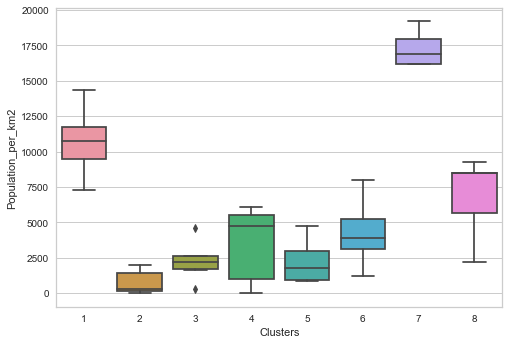

In [286]:
pos=[0,1,2,3,4,5,6,7]
labels = list('12345678')
ax=sns.boxplot(data=[clusters[i]['Population_per_km2'] for i in range(8)])
ax.set(xlabel='Clusters',ylabel='Population_per_km2',xticks=pos,xticklabels=labels);

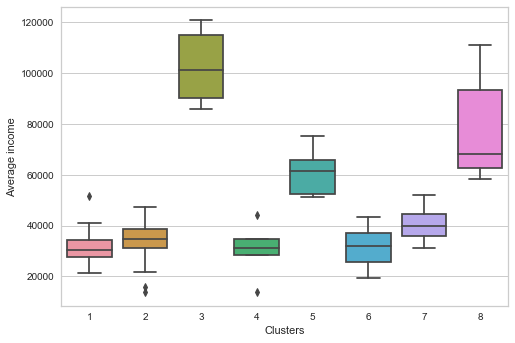

In [287]:
pos=[0,1,2,3,4,5,6,7]
labels = list('12345678')
ax=sns.boxplot(data=[clusters[i]['Average income'] for i in range(8)])
ax.set(xlabel='Clusters',ylabel='Average income',xticks=pos,xticklabels=labels);

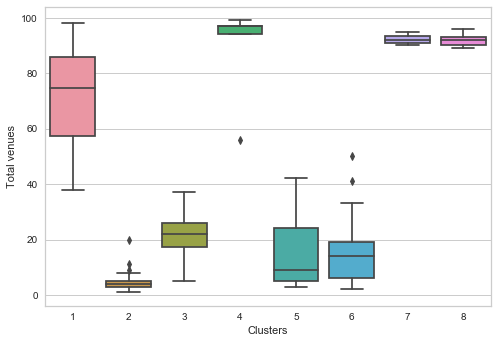

In [285]:
pos=[0,1,2,3,4,5,6,7]
labels = list('12345678')
ax=sns.boxplot(data=[clusters[i]['total_venues'] for i in range(8)])
ax.set(xlabel='Clusters',ylabel='Total venues',xticks=pos,xticklabels=labels);

#### Looking at the above comparison one can see that that clusters 1, 2, 4, 6 and 7 are towards the lower end of the income spectrum therefore these areas would not be very suitable for opening a restaurant targetting the mid to upper level restaurant.
#### Cluster 8 includes areas with high average income but looking at the number of venues there this area has very high competition. The last two remaining clusters 3 and 5 seem promissing. The neighborhoods included in these clusters have a good income and the competition is also not that high. The population density is on the lower side but with sufficient buying power the restaurant can still do good business with regular customers and high profit margins.
#### The shortlisted neighborhoods are shown below.

In [316]:
clusters[2][clusters[2].Neighborhood.isin(['Nienstedten','Wohldorf-Ohlstedt'])].append(clusters[4][clusters[4].Neighborhood.isin(['Rissen','Lemsahl-Mellingstedt','Duvenstedt'])])


,Neighborhood,Population,Population_per_km2,Average income,total_venues,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Nienstedten,7181,1670,120716.0,17,2,Café,Seafood Restaurant,Snack Place,Restaurant,German Restaurant,French Restaurant,Portuguese Restaurant,Diner,Fried Chicken Joint,Ethiopian Restaurant
69,Wohldorf-Ohlstedt,4650,269,94234.0,5,2,German Restaurant,Wings Joint,Food Truck,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
32,Rissen,15886,951,65855.0,3,4,Indian Restaurant,German Restaurant,Café,Wings Joint,Food Court,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
67,Lemsahl-Mellingstedt,6852,857,75191.0,5,4,German Restaurant,Restaurant,Pizza Place,Seafood Restaurant,Food,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
68,Duvenstedt,6160,906,65694.0,5,4,Café,Pizza Place,German Restaurant,Modern European Restaurant,Burger Joint,Wings Joint,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant


#### It can be seen that although population density is not high in these areas but people living in these areas have a high buying power. Moreover the competition is relatively low and only those neighborhoods are selected where there are no italian restaurants in the top 10 food venues. 

## Conclusion

#### It is shown through this project that data science and machine learning can be used to make effective business decisions. Machine learning models like K-Means clustering can be used to get insights into data by using a large amount of data, which would otherwise not be possible just by looking at it.  
#### In this project neighborhoods of Hamburg are analyzed to shortlist optimum locations for opening an Italian restaurant catering to the mid to upper end segment of the market. Taking the targeted customers into consideration locations are shortlisted using data on food venues from foursquare API, and information on average income and population density available on the internet.  
#### Five neighborhoods are shortlisted where the population has high buying power and the competition is low. The stakeholder may consider other factors like real estate availability, running cost, availability of workforce etc. before making a final decision. 